In [74]:
# boas práticas: criar uma célula com todas as bibliotecas necessárias
# importando as bibliotecas necessárias
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [252]:
# Turmas 2017.2
# http://dados.ufrn.br/dataset/turmas

# turmas
turmas_url = 'http://bit.do/turmas_ufrn_2017_2'

# matrículas em componentes em 2017.2
notas_url = 'http://bit.do/notas_ufrn_2017_2'

# componentes curriculares presenciais
disciplinas_url = 'http://bit.do/componentes_curriculares_ufrn'

# turmas 2017.2
turmas = pd.read_csv(turmas_url, sep=';')

# matriculas em componentes em 2017.2
notas = pd.read_csv(notas_url, sep=';')

# componentes curriculares presenciais
# por alguma razão ou outra, esse dataset tinha algum lixo em linhas que ocasionava 
# erros de leitura, dessa forma foi realizado um filtro apenas por colunas mais importantes
disciplinas = pd.read_csv(disciplinas_url, 
                          sep=';', 
                          usecols=["id_componente","codigo","nivel","nome","unidade_responsavel"])

In [253]:
# Turmas 2017.1
# http://dados.ufrn.br/dataset/turmas

# turmas
turmas_url_2017_1 = 'http://bit.do/turmas_ufrn_2017_1'

# matrículas em componentes em 2017.2
notas_url_2017_1 = 'http://bit.do/notas_ufrn_2017_1'

# turmas 2017.1
turmas_2017_1 = pd.read_csv(turmas_url_2017_1, sep=';')

# matriculas em componentes em 2017.1
notas_2017_1 = pd.read_csv(notas_url_2017_1, sep=';')

In [254]:
# Adaptando o dataframe turma e disciplinas para o merge
# Esse procedimento é necessário pois o dataframe turma está codificado com ids

# A coluna id_componente precisa ser a mesma em ambos os dataframes
turmas.rename(columns={'id_componente_curricular': 'id_componente'}, inplace=True)
turmas_2017_1.rename(columns={'id_componente_curricular': 'id_componente'}, inplace=True)

# id_componente em ambos os dataframes precisam ser do mesmo tipo
turmas.id_componente = turmas.id_componente.astype(str)
turmas_2017_1.id_componente = turmas_2017_1.id_componente.astype(str)

# Limpando o dataframe disciplinas com linhas desnecessárias
disciplinas = disciplinas[~disciplinas.id_componente.duplicated()]

# Pegando apenas as disciplinas do IMD
disciplinas = disciplinas[disciplinas.unidade_responsavel == 'INSTITUTO METROPOLE DIGITAL']

In [255]:
# Fazendo um merge entre o dataframe turmas e disciplinas utilizando como base a coluna id_componente
# https://pandas.pydata.org/pandas-docs/stable/merging.html
colunas = ["id_turma","codigo","nivel_ensino","nome","unidade_responsavel",
          "situacao_turma","capacidade_aluno","descricao_horario", "ano", "periodo"]

# merge os dois dataframes utilizando como base a coluna id_componenteb
disciplinas_turma = pd.merge(turmas, disciplinas, on='id_componente')[colunas]
disciplinas_turma_2017_1 = pd.merge(turmas_2017_1, disciplinas, on='id_componente')[colunas]

In [256]:
colunas_relevantes = ["id_turma", "codigo", "nome", "descricao_horario", "ano", 
                      "periodo", "media_final", "numero_total_faltas", "descricao", "discente"]
# Merge de turma com as notas
notas_turma = pd.merge(disciplinas_turma, notas, on='id_turma')[colunas_relevantes]
notas_turma_turma_2017_1 = pd.merge(disciplinas_turma_2017_1, notas_2017_1, on='id_turma')[colunas_relevantes]

In [257]:
%%javascript
// Para evitar dos graficos ficarem contidos numa caixa com scroll
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

[Text(0,0.5,'Faltas')]

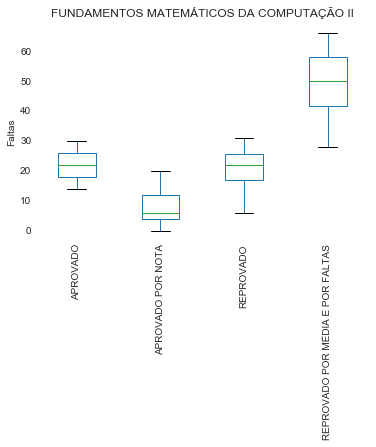

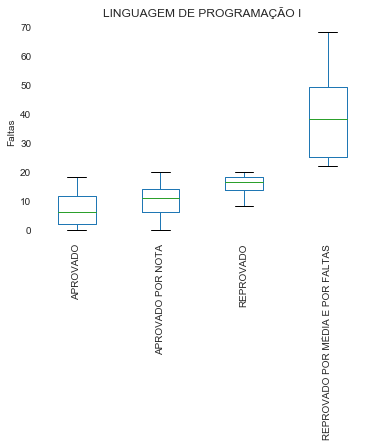

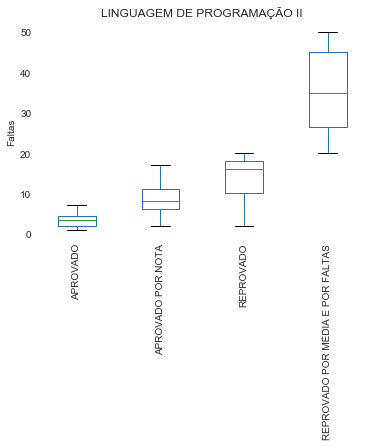

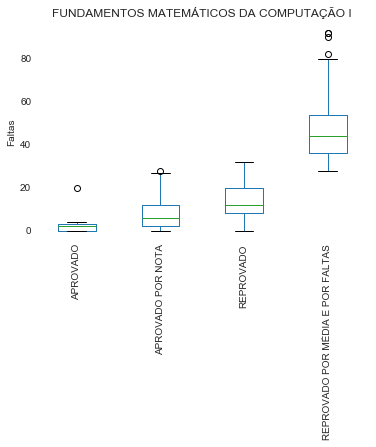

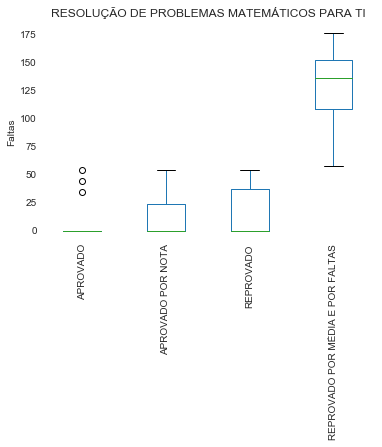

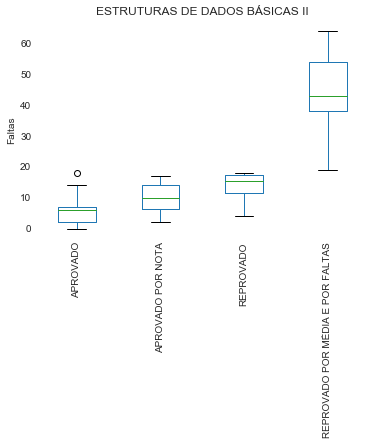

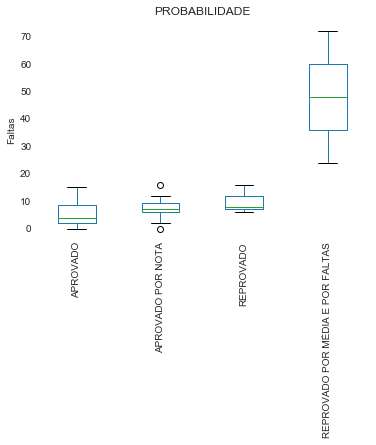

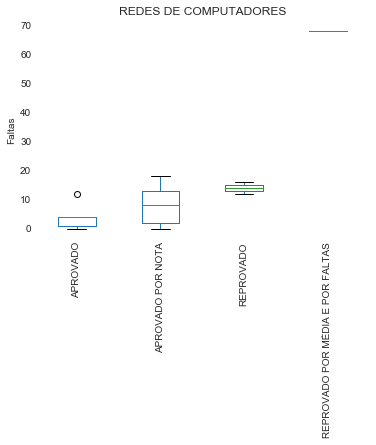

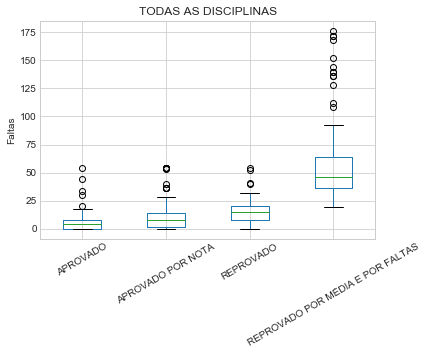

In [258]:
sns.set_style("whitegrid")

disciplinas = (
    'FUNDAMENTOS MATEMÁTICOS DA COMPUTAÇÃO II',
    'LINGUAGEM DE PROGRAMAÇÃO I',
    'LINGUAGEM DE PROGRAMAÇÃO II',
    'FUNDAMENTOS MATEMÁTICOS DA COMPUTAÇÃO I',
    'RESOLUÇÃO DE PROBLEMAS MATEMÁTICOS PARA TI',
    'ESTRUTURAS DE DADOS BÁSICAS II',
    'PROBABILIDADE',
    'REDES DE COMPUTADORES'
)
# Aqui é gerado um dicionário em que a chave é o nome da disciplina e o valor é um dataframe contendo as
# notas para aquela disciplina. Como a disciplina tem mais de uma unidade, a quantidade de faltas aparece em um
# numero igual a quantidade de unidades. Para evitar isso e gerar incosistências na análise foi removido esses
# dados duplicados e deixado apenas um por discente.
dataframes_notas = {}
for disciplina in disciplinas:
    dataframes_notas[disciplina] = notas_turma[notas_turma.nome == disciplina].drop_duplicates('discente')
    
# Aqui percorremos o dataframes_notas, montado anteriormente, e criamos o dataframe_grupos, que também tem como 
# chave o nome das disciplinas e um dataframe contendo os grupos de aprovaçoes como colunas.
dataframes_grupos = {}
for (disciplina, dataframe) in dataframes_notas.items():
    lista_status = list(filter(lambda i : i not in ('INDEFERIDO', 'TRANCADO', 'DESISTENCIA', 'EXCLUIDA', 'REPROVADO POR NOTA', 'CANCELADO'), dataframe.descricao.unique()))
    dataframe_montado = {}
    for status in lista_status:
        dataframe_montado[status] = dataframe[dataframe.descricao == status]['numero_total_faltas']
    dataframes_grupos[disciplina] = pd.DataFrame.from_dict(dataframe_montado)

# Aqui percorremos o dicionário de dataframes e criamos um gráfico para cada um.
for disciplina, dataframe in dataframes_grupos.items():
    ax = dataframe.plot(kind='box', rot=90, title=disciplina)
    ax.set(ylabel='Faltas')
    ax.grid(False)
    for key, spine in ax.spines.items():
        spine.set_visible(False)
        

    
# Graficos para um dataframe com a junção dos dataframes de todas as disciplinas
dataframe_todos = pd.concat(dataframes_grupos.values())
dataframe_todos.plot(kind='box', rot=30, title='TODAS AS DISCIPLINAS').set(ylabel='Faltas')
#dataframe_todos.plot(kind='kde', rot=30, title='TODAS AS DISCIPLINAS').set(xlabel='Faltas')

[Text(0,0.5,'Faltas')]

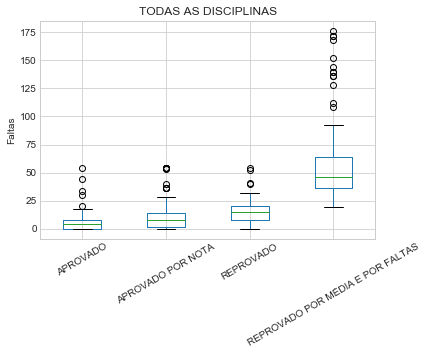

In [259]:
# Aqui é gerado um dicionário em que a chave é o nome da disciplina e o valor é um dataframe contendo as
# notas para aquela disciplina. Como a disciplina tem mais de uma unidade, a quantidade de faltas aparece em um
# numero igual a quantidade de unidades. Para evitar isso e gerar incosistências na análise foi removido esses
# dados duplicados e deixado apenas um por discente.
dataframes_notas_2017_1 = {}
for disciplina in disciplinas:
    dataframes_notas_2017_1[disciplina] = notas_turma_turma_2017_1[notas_turma_turma_2017_1.nome == disciplina].drop_duplicates('discente')

# Aqui percorremos o dataframes_notas, montado anteriormente, e criamos o dataframe_grupos, que também tem como 
# chave o nome das disciplinas e um dataframe contendo os grupos de aprovaçoes como colunas.
dataframes_grupos_2017_1 = {}
for (disciplina, dataframe_2017_1) in dataframes_notas.items():
    lista_status = list(filter(lambda i : i not in ('INDEFERIDO', 'TRANCADO', 'DESISTENCIA', 'EXCLUIDA', 'REPROVADO POR NOTA', 'CANCELADO'), dataframe_2017_1.descricao.unique()))
    dataframe_montado_2017_1 = {}
    for status in lista_status:
        dataframe_montado_2017_1[status] = dataframe_2017_1[dataframe_2017_1.descricao == status]['numero_total_faltas']
    dataframes_grupos_2017_1[disciplina] = pd.DataFrame.from_dict(dataframe_montado_2017_1)
    
    
    
    
# Graficos para um dataframe com a junção dos dataframes de todas as disciplinas
dataframe_todos_2017_1 = pd.concat(dataframes_grupos_2017_1.values())
dataframe_todos_2017_1.plot(kind='box', rot=30, title='TODAS AS DISCIPLINAS').set(ylabel='Faltas')